In [0]:
# Imports all the required modules function

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


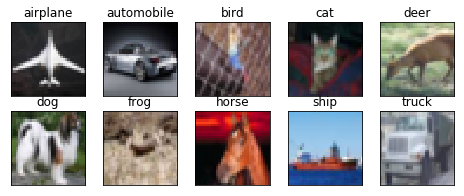

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#Function for plotting model history
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Function for calculating validation test 
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(48, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(192, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)        41568     
__________

In [0]:
from keras.callbacks import  ModelCheckpoint  # importing checkpoint

filepath="/content/gdrive/My Drive/EVA_session_6-3.3_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"                                  # filepath in google drive to save weights
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)    # checkpoint to monitor validation accuracy, and save which give max accuracy

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
390/390 [==============================] - 15s 38ms/step - loss: 1.8483 - acc: 0.2970 - val_loss: 1.5241 - val_acc: 0.4324

Epoch 00001: acc improved from -inf to 0.29704, saving model to /content/gdrive/My Drive/EVA_session_6-3.3_weights-improvement-01-0.43.hdf5
Epoch 2/100
390/390 [==============================] - 10s 25ms/step - loss: 1.3448 - acc: 0.5111 - val_loss: 1.1321 - val_acc: 0.5995

Epoch 00002: acc improved from 0.29704 to 0.51121, saving model to /content/gdrive/My Drive/EVA_session_6-3.3_weights-improvement-02-0.60.hdf5
Epoch 3/100
390/390 [==============================] - 9s 24ms/step - loss: 1.1157 - acc: 0.6063 - val_loss: 0.9934 - val_acc: 0.6437

Epoch 00003: acc improved from 0.51121 to 0.60631, saving model to /content/gdrive/My Drive/EVA_session_6-3.3_weights-improvement-03-0.64.hdf5
Epoch 4/100
390/390 [==============================] - 9s 23ms/step - loss: 0.9686 - acc: 0.6612 - val_loss: 0.8688 - v

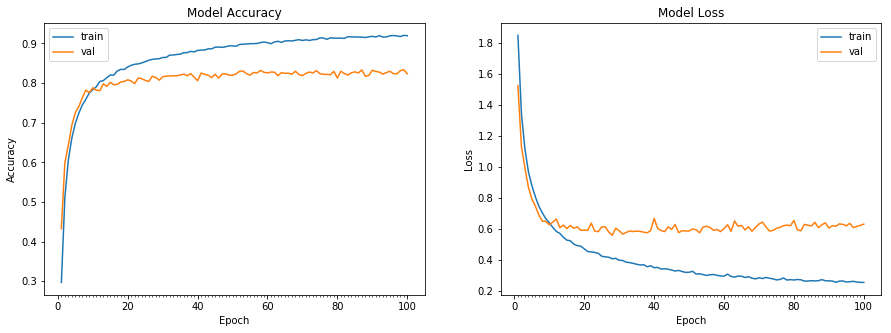

Accuracy on test data is: 82.34


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), 
                                 callbacks=[checkpoint],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

# Below architecture acheived 96.15% training accuracy in 50 epoch VS  92.03% in 100 epochs above

In [0]:
from keras.callbacks import  ModelCheckpoint  # importing checkpoint

filepath="/content/gdrive/My Drive/EVA_session_6-3.4_weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"                                  # filepath in google drive to save weights
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max',save_weights_only=True)    # checkpoint to monitor validation accuracy, and save which give max accuracy

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(64, 3, 3, activation='relu',border_mode='same',input_shape=(32, 32, 3)))  # 30 , 3
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))  # 28 , 5
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2, 2))) # 14,10
model.add(Convolution2D(20, 1, 1, activation='relu')) 
model.add(BatchNormalization())

model.add(Convolution2D(256, 3, 3,border_mode='same',activation='relu'))  # 12 , 12
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(MaxPooling2D(pool_size=(2, 2))) # 6, 24
model.add(Convolution2D(20, 1, 1, activation='relu')) 
model.add(BatchNormalization())

model.add(Convolution2D(128, 3, 3,border_mode='same',activation='relu'))  # 4 , 26
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(10, 1, activation='relu')) 
model.add(BatchNormalization())
model.add(Convolution2D(num_classes, 8))
model.add(Flatten())
model.add(Activation('softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
__________

Epoch 1/50
390/390 [==============================] - 26s 65ms/step - loss: 1.3980 - acc: 0.4962 - val_loss: 1.2839 - val_acc: 0.5515

Epoch 00001: acc improved from -inf to 0.49615, saving model to /content/gdrive/My Drive/EVA_session_6-3.4_weights-improvement-01-0.55.hdf5
Epoch 2/50
390/390 [==============================] - 24s 61ms/step - loss: 0.9792 - acc: 0.6499 - val_loss: 1.0151 - val_acc: 0.6462

Epoch 00002: acc improved from 0.49615 to 0.64996, saving model to /content/gdrive/My Drive/EVA_session_6-3.4_weights-improvement-02-0.65.hdf5
Epoch 3/50
390/390 [==============================] - 23s 60ms/step - loss: 0.8109 - acc: 0.7147 - val_loss: 0.8368 - val_acc: 0.7134

Epoch 00003: acc improved from 0.64996 to 0.71487, saving model to /content/gdrive/My Drive/EVA_session_6-3.4_weights-improvement-03-0.71.hdf5
Epoch 4/50
390/390 [==============================] - 23s 60ms/step - loss: 0.7089 - acc: 0.7511 - val_loss: 0.9592 - val_acc: 0.6669

Epoch 00004: acc improved from 0.7

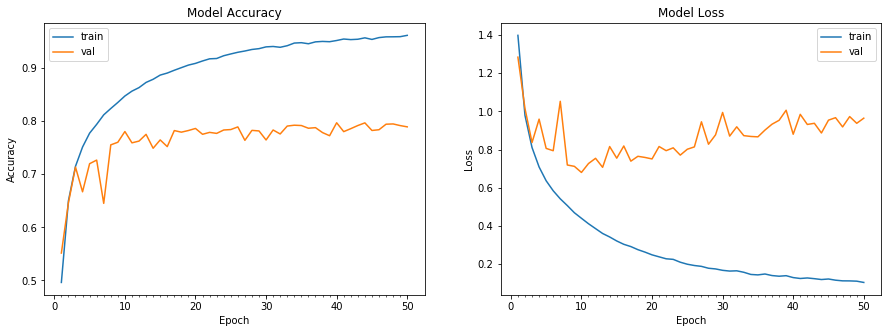

Accuracy on test data is: 78.92


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels),
                                 callbacks=[checkpoint],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))